<a href="https://colab.research.google.com/github/chavalvit-k/OKCupid-Age-Groups-Classification-with-ML-DL/blob/main/OKCupid_Age_Groups_Classification_with_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option("display.max_columns", None)

# Import Dataset

In [4]:
df = pd.read_csv("profiles.csv")

In [5]:
df.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


# Preprocess

## Focus Only People Below 60 Years Old

In [6]:
df = df[df["age"] <= 60]

## Handle `body_type`

### Convert to New Classes

In [7]:
df["body_type"].unique()

array(['a little extra', 'average', 'thin', 'athletic', 'fit', nan,
       'skinny', 'curvy', 'full figured', 'jacked', 'rather not say',
       'used up', 'overweight'], dtype=object)

In [8]:
body_type_map_table = {
    "thin": "thin",
    "skinny": "thin",

    "fit": "fit",
    "athletic": "fit",
    "jacked": "fit",

    "average": "average",

    "curvy": "curvy",
    "full figured": "curvy",

    "overweight": "overweight",
    "a little extra": "overweight",
}

df["body_type"] = df["body_type"].map(body_type_map_table)
df["body_type"].unique()

array(['overweight', 'average', 'thin', 'fit', nan, 'curvy'], dtype=object)

### Handle Missing Values

In [9]:
df["body_type"].isnull().sum()

5802

In [10]:
body_type_counts = df["body_type"].value_counts(normalize = True)
missing_index = df[df["body_type"].isnull()].index

filled_values = np.random.choice(body_type_counts.index,
                                 size = len(missing_index),
                                 p = body_type_counts.values)

df.loc[missing_index, "body_type"] = filled_values

In [11]:
df["body_type"].isnull().sum()

0

## Handle `diet`

### Convert to New Classes

In [12]:
df["diet"].unique()

array(['strictly anything', 'mostly other', 'anything', 'vegetarian', nan,
       'mostly anything', 'mostly vegetarian', 'strictly vegan',
       'strictly vegetarian', 'mostly vegan', 'strictly other',
       'mostly halal', 'other', 'vegan', 'mostly kosher',
       'strictly halal', 'halal', 'strictly kosher', 'kosher'],
      dtype=object)

In [13]:
diet_map_table = {
    "anything": "anything",
    "mostly anything": "anything",
    "strictly anything": "anything",

    "vegan": "vegan",
    "mostly vegan": "vegan",
    "strictly vegan": "vegan",

    "vegetarian": "vegetarian",
    "mostly vegetarian": "vegetarian",
    "strictly vegetarian": "vegetarian",

    "halal": "halal",
    "mostly halal": "halal",
    "strictly halal": "halal",

    "kosher": "kosher",
    "mostly kosher": "kosher",
    "strictly kosher": "kosher"
}

df["diet"] = df["diet"].map(diet_map_table)
df["diet"].unique()

array(['anything', nan, 'vegetarian', 'vegan', 'halal', 'kosher'],
      dtype=object)

### Handle Missing Values

In [14]:
df["diet"].isnull().sum()

25739

In [15]:
diet_counts = df["diet"].value_counts(normalize = True)
missing_index = df[df["diet"].isnull()].index

filled_values = np.random.choice(diet_counts.index,
                                 size = len(missing_index),
                                 p = diet_counts.values)

df.loc[missing_index, "diet"] = filled_values

In [16]:
df["diet"].isnull().sum()

0

## Handle `drinks`

### Convert to New Classes

In [17]:
df["drinks"].unique()

array(['socially', 'often', 'not at all', 'rarely', nan, 'very often',
       'desperately'], dtype=object)

In [18]:
drinks_map_table = {
    "not at all": "no",

    "rarely": "sometimes",
    "socially": "sometimes",

    "often": "frequent",
    "very often": "frequent",
    "desperately": "frequent"
}

df["drinks"] = df["drinks"].map(drinks_map_table)
df["drinks"].unique()

array(['sometimes', 'frequent', 'no', nan], dtype=object)

### Handle Missing Values

In [19]:
df["drinks"].isnull().sum()

2952

In [20]:
drinks_counts = df["drinks"].value_counts(normalize = True)
missing_index = df[df["drinks"].isnull()].index

filled_values = np.random.choice(drinks_counts.index,
                                 size = len(missing_index),
                                 p = drinks_counts.values)

df.loc[missing_index, "drinks"] = filled_values

In [21]:
df["drinks"].isnull().sum()

0

## Handle `drugs`

### Handle Missing Values

In [22]:
df["drugs"].isnull().sum()

13987

In [23]:
drugs_counts = df["drugs"].value_counts(normalize = True)
missing_index = df[df["drugs"].isnull()].index

filled_values = np.random.choice(drugs_counts.index,
                                 size = len(missing_index),
                                 p = drugs_counts.values)

df.loc[missing_index, "drugs"] = filled_values

In [24]:
df["drugs"].isnull().sum()

0

## Handle `education`

### Convert to New Classes

In [25]:
df["education"].unique()

array(['working on college/university', 'working on space camp',
       'graduated from masters program',
       'graduated from college/university', 'working on two-year college',
       nan, 'graduated from high school', 'working on masters program',
       'graduated from space camp', 'college/university',
       'dropped out of space camp', 'graduated from ph.d program',
       'graduated from law school', 'working on ph.d program',
       'two-year college', 'graduated from two-year college',
       'working on med school', 'dropped out of college/university',
       'space camp', 'graduated from med school',
       'dropped out of high school', 'working on high school',
       'dropped out of two-year college', 'dropped out of med school',
       'high school', 'dropped out of ph.d program',
       'working on law school', 'law school', 'masters program',
       'dropped out of masters program', 'ph.d program',
       'dropped out of law school', 'med school'], dtype=object)

In [26]:
df["education"] = np.where(df["education"].str.contains("dropped out", na = False), "dropped out", df["education"])
df["education"] = np.where(df["education"].str.contains("graduated", na = False), "graduated", df["education"])
df["education"] = np.where(~ df["education"].str.contains("dropped out|graduated", regex = True, na = False), "studying", df["education"])

In [27]:
df["education"].unique()

array(['studying', 'graduated', 'dropped out'], dtype=object)

### Handle Missing Values

In [28]:
df["education"].isnull().sum()

0

In [29]:
education_counts = df["education"].value_counts(normalize = True)
missing_index = df[df["education"].isnull()].index

filled_values = np.random.choice(education_counts.index,
                                 size = len(missing_index),
                                 p = education_counts.values)

df.loc[missing_index, "education"] = filled_values

In [30]:
df["education"].isnull().sum()

0

## Handle `income`

### Handle Negative Income

In [31]:
df["income"].value_counts()

,count
income,
-1,47672
20000,2935
100000,1587
80000,1079
30000,1030
40000,986
50000,949
60000,717
70000,693


In [32]:
df["income"] = df["income"].replace(-1, 0)
df["income"].value_counts()

,count
income,
0,47672
20000,2935
100000,1587
80000,1079
30000,1030
40000,986
50000,949
60000,717
70000,693


## Handle `job`

### Convert to New Classes

In [33]:
df["job"].unique()

array(['transportation', 'hospitality / travel', nan, 'student',
       'artistic / musical / writer', 'computer / hardware / software',
       'banking / financial / real estate', 'entertainment / media',
       'sales / marketing / biz dev', 'other', 'medicine / health',
       'science / tech / engineering', 'executive / management',
       'education / academia', 'clerical / administrative',
       'construction / craftsmanship', 'rather not say',
       'political / government', 'law / legal services', 'unemployed',
       'military', 'retired'], dtype=object)

In [34]:
job_map_table = {
    "transportation": "transportation",

    "hospitality / travel": "travel",

    "artistic / musical / writer": "artist",

    "computer / hardware / software": "science",
    "science / tech / engineering": "science",

    "banking / financial / real estate": "financial",

    "entertainment / media": "entertainment",

    "sales / marketing / biz dev": "buisness",
    "executive / management": "buisness",

    "medicine / health": "health",

    "education / academia": "education",

    "clerical / administrative": "clerical",

    "construction / craftsmanship": "construction",

    "political / government": "political",

    "law / legal services": "law",

    "militrary": "militrary",

    "student": "student",

    "unemployed": "unemployed",

    "retired": "retired"
}

df["job"] = df["job"].map(job_map_table)
df["job"].unique()

array(['transportation', 'travel', nan, 'student', 'artist', 'science',
       'financial', 'entertainment', 'buisness', 'health', 'education',
       'clerical', 'construction', 'political', 'law', 'unemployed',
       'retired'], dtype=object)

### Handle Missing Values

In [35]:
df["job"].isnull().sum()

16165

In [36]:
job_counts = df["job"].value_counts(normalize = True)
missing_index = df[df["job"].isnull()].index

filled_values = np.random.choice(job_counts.index,
                                 size = len(missing_index),
                                 p = job_counts.values)

df.loc[missing_index, "job"] = filled_values

In [37]:
df["job"].isnull().sum()

0

## Handle `offspring`

### Convert to New Classes

In [38]:
df["offspring"].unique()

array(['doesn&rsquo;t have kids, but might want them', nan,
       'doesn&rsquo;t want kids',
       'doesn&rsquo;t have kids, but wants them',
       'doesn&rsquo;t have kids', 'wants kids', 'has a kid', 'has kids',
       'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
       'has kids, but doesn&rsquo;t want more',
       'has a kid, but doesn&rsquo;t want more',
       'has a kid, and wants more', 'has kids, and might want more',
       'might want kids', 'has a kid, and might want more',
       'has kids, and wants more'], dtype=object)

In [39]:
df["offspring"] = np.where(df["offspring"].str.contains("has", na = False), 1, df["offspring"])
df["offspring"] = np.where(df["offspring"].str.contains("kids", na = False), 0, df["offspring"])
df["offspring"].unique()

array([0, nan, 1], dtype=object)

### Handle Missing Values

In [40]:
df["offspring"].isnull().sum()

35273

In [41]:
offspring_counts = df["offspring"].value_counts(normalize = True)
missing_index = df[df["offspring"].isnull()].index

filled_values = np.random.choice(offspring_counts.index,
                                 size = len(missing_index),
                                 p = offspring_counts.values)

df.loc[missing_index, "offspring"] = filled_values

In [42]:
df["offspring"].isnull().sum()

0

## Handle `religion`

### Convert to New Classes

In [43]:
df["religion"].unique()

array(['agnosticism and very serious about it',
       'agnosticism but not too serious about it', nan, 'atheism',
       'christianity', 'christianity but not too serious about it',
       'atheism and laughing about it',
       'christianity and very serious about it', 'other', 'catholicism',
       'catholicism but not too serious about it',
       'catholicism and somewhat serious about it',
       'agnosticism and somewhat serious about it',
       'catholicism and laughing about it',
       'agnosticism and laughing about it', 'agnosticism',
       'atheism and somewhat serious about it',
       'buddhism but not too serious about it',
       'other but not too serious about it', 'buddhism',
       'other and laughing about it',
       'judaism but not too serious about it',
       'buddhism and laughing about it',
       'other and somewhat serious about it',
       'other and very serious about it',
       'hinduism but not too serious about it',
       'atheism but not too ser

In [44]:
df["religion"] = np.where(df["religion"].str.contains("very|somewhat", regex = True, na = False), "serious", df["religion"])
df["religion"] = np.where(df["religion"].str.contains("not|laughing", regex = True, na = False), "not serious", df["religion"])
df["religion"] = np.where(~ df["religion"].str.contains("serious", regex = True, na = False), np.nan, df["religion"])
df["religion"].unique()

array(['serious', 'not serious', nan], dtype=object)

### Handle Missing Values

In [45]:
df["religion"].isnull().sum()

31618

In [46]:
religion_counts = df["religion"].value_counts(normalize = True)
missing_index = df[df["religion"].isnull()].index

filled_values = np.random.choice(religion_counts.index,
                                 size = len(missing_index),
                                 p = religion_counts.values)

df.loc[missing_index, "religion"] = filled_values

In [47]:
df["religion"].isnull().sum()

0

## Handle `smokes`

### Convert to New Classes

In [48]:
df["smokes"].unique()

array(['sometimes', 'no', nan, 'when drinking', 'yes', 'trying to quit'],
      dtype=object)

In [49]:
smokes_map_table = {
    "no": "no",

    "sometimes": "sometimes",
    "trying to quit": "sometimes",
    "when drinking": "sometimes",

    "yes": "yes"
}

df["smokes"] = df["smokes"].map(smokes_map_table)
df["smokes"].unique()

array(['sometimes', 'no', nan, 'yes'], dtype=object)

### Handle Missing Values

In [50]:
df["smokes"].isnull().sum()

5480

In [51]:
smokes_counts = df["smokes"].value_counts(normalize = True)
missing_index = df[df["smokes"].isnull()].index

filled_values = np.random.choice(smokes_counts.index,
                                 size = len(missing_index),
                                 p = smokes_counts.values)

df.loc[missing_index, "smokes"] = filled_values

In [52]:
df["smokes"].isnull().sum()

0

## Handle `status`

### Convert to New Classes

In [53]:
df["status"].unique()

array(['single', 'available', 'seeing someone', 'married', 'unknown'],
      dtype=object)

In [54]:
status_map_table = {
    "single": "single",
    "available": "single",

    "seeing someone": "dating",

    "married": "married",
}

df["status"] = df["status"].map(status_map_table)
df["status"].unique()

array(['single', 'dating', 'married', nan], dtype=object)

### Handle Missing Values

In [55]:
df["status"].isnull().sum()

10

In [56]:
status_counts = df["status"].value_counts(normalize = True)
missing_index = df[df["status"].isnull()].index

filled_values = np.random.choice(status_counts.index,
                                 size = len(missing_index),
                                 p = status_counts.values)

df.loc[missing_index, "status"] = filled_values

In [57]:
df["status"].isnull().sum()

0

# Select Features and Target

In [58]:
features = ["body_type", "diet", "drinks", "drugs", "education", "income", "job", "offspring", "religion", "smokes", "status"]

X = df[features]
y = df["age"]

In [59]:
X.head()

,body_type,diet,drinks,drugs,education,income,job,offspring,religion,smokes,status
0,overweight,anything,sometimes,never,studying,0,transportation,0,serious,sometimes,single
1,average,anything,frequent,sometimes,studying,80000,travel,0,not serious,no,single
2,thin,anything,sometimes,never,graduated,0,science,0,serious,no,single
3,thin,vegetarian,sometimes,never,studying,20000,student,0,not serious,no,single
4,fit,anything,sometimes,never,graduated,0,artist,1,serious,no,single


In [60]:
y.head()

,age
0,22
1,35
2,38
3,23
4,29


# Discretize Feature

In [61]:
X["income"].value_counts().sort_index()

,count
income,
0,47672
20000,2935
30000,1030
40000,986
50000,949
60000,717
70000,693
80000,1079
100000,1587


In [62]:
bins = [-1, 0, 50000, 150000, 1000000]
labels = ["no income", "low", "medium", "high"]

X["income"] = pd.cut(X["income"], bins = bins, labels = labels)

<ipython-input-62-a20394602fcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["income"] = pd.cut(X["income"], bins = bins, labels = labels)


In [63]:
X["income"].value_counts()

,count
income,
no income,47672
low,5900
medium,4693
high,715


# One-Hot Encode Features

In [64]:
X = pd.get_dummies(X, columns = features)
X.head()

,body_type_average,body_type_curvy,body_type_fit,body_type_overweight,body_type_thin,diet_anything,diet_halal,diet_kosher,diet_vegan,diet_vegetarian,drinks_frequent,drinks_no,drinks_sometimes,drugs_never,drugs_often,drugs_sometimes,education_dropped out,education_graduated,education_studying,income_no income,income_low,income_medium,income_high,job_artist,job_buisness,job_clerical,job_construction,job_education,job_entertainment,job_financial,job_health,job_law,job_political,job_retired,job_science,job_student,job_transportation,job_travel,job_unemployed,offspring_0,offspring_1,religion_not serious,religion_serious,smokes_no,smokes_sometimes,smokes_yes,status_dating,status_married,status_single
0,False,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True
1,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False,False,True
2,False,False,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True
3,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True
4,False,False,True,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,True


# Discretize Target

In [65]:
y.value_counts().sort_index()

,count
age,
18,309
19,611
20,953
21,1282
22,1934
23,2592
24,3242
25,3531
26,3724


In [66]:
bins = [0, 25, 35, 45, 60]
labels = ["young", "young-adult", "adult", "middle-aged"]

y = pd.cut(y, bins = bins, labels = labels)

In [67]:
y.value_counts().sort_index()

,count
age,
young,14454
young-adult,28621
adult,10803
middle-aged,5102


# Split Training Set and Testing Set

In [68]:
X = X.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y, random_state = 42)

# Balance Training Set

In [69]:
y_train.value_counts()

,count
age,
young-adult,20035
young,10118
adult,7562
middle-aged,3571


<Axes: xlabel='age'>

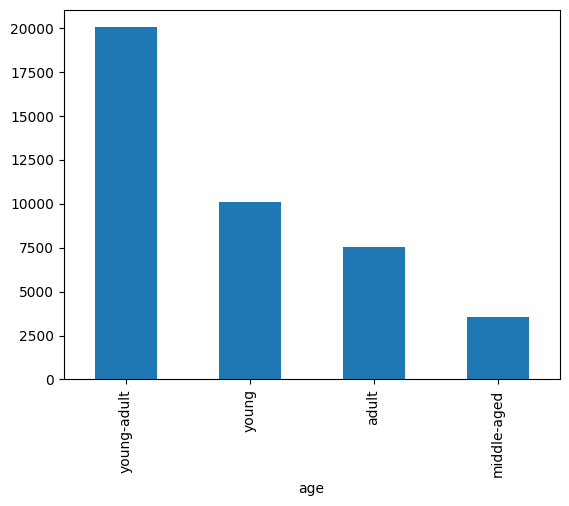

In [70]:
y_train.value_counts().plot(kind = "bar")

In [71]:
smote = SMOTE(random_state = 42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [72]:
y_train_resampled.value_counts()

,count
age,
young,20035
young-adult,20035
adult,20035
middle-aged,20035


<Axes: xlabel='age'>

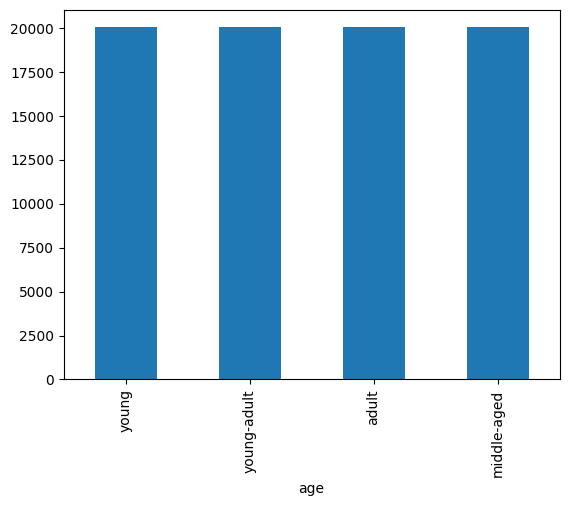

In [73]:
y_train_resampled.value_counts().plot(kind = "bar")

# Build Dummy Model (Baseline)

In [74]:
scores = []

In [75]:
dummy_model = DummyClassifier(strategy = "stratified")

dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [76]:
y_pred_train = dummy_model.predict(X_train)
y_pred_test = dummy_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.3343
Test accuracy: 0.3349


In [77]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.18      0.18      0.18      3241
 middle-aged       0.09      0.09      0.09      1531
       young       0.24      0.25      0.24      4336
 young-adult       0.48      0.48      0.48      8586

    accuracy                           0.33     17694
   macro avg       0.25      0.25      0.25     17694
weighted avg       0.34      0.33      0.33     17694



In [78]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["Dummy Model (Baseline)", accuracy, f1])

# Build Machine Learning Models

## Decision Tree

### Without Balancing

In [79]:
dt_model = DecisionTreeClassifier()

dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [80]:
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.6422
Test accuracy: 0.4647


In [81]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.23      0.13      0.17      3241
 middle-aged       0.24      0.15      0.18      1531
       young       0.46      0.36      0.40      4336
 young-adult       0.52      0.70      0.60      8586

    accuracy                           0.46     17694
   macro avg       0.36      0.33      0.34     17694
weighted avg       0.43      0.46      0.44     17694



In [82]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["Decision Tree: Without Balancing", accuracy, f1])

### With Balancing

In [83]:
dt_model = DecisionTreeClassifier()

dt_model.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

In [84]:
y_pred_train = dt_model.predict(X_train_resampled)
y_pred_test = dt_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train_resampled, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.6311
Test accuracy: 0.3817


In [85]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.23      0.36      0.28      3241
 middle-aged       0.20      0.27      0.23      1531
       young       0.42      0.43      0.43      4336
 young-adult       0.54      0.39      0.45      8586

    accuracy                           0.38     17694
   macro avg       0.35      0.36      0.35     17694
weighted avg       0.42      0.38      0.39     17694



In [86]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["Decision Tree: With Balancing", accuracy, f1])

## Random Forest

### Without Balancing

In [87]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [88]:
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.6422
Test accuracy: 0.4884


In [89]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.25      0.09      0.14      3241
 middle-aged       0.28      0.14      0.18      1531
       young       0.49      0.34      0.40      4336
 young-adult       0.52      0.78      0.62      8586

    accuracy                           0.49     17694
   macro avg       0.39      0.34      0.34     17694
weighted avg       0.44      0.49      0.44     17694



In [90]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["Random Forest: Without Balancing", accuracy, f1])

### With Balancing

In [91]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [92]:
y_pred_train = rf_model.predict(X_train_resampled)
y_pred_test = rf_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train_resampled, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.6311
Test accuracy: 0.3962


In [93]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.23      0.32      0.27      3241
 middle-aged       0.20      0.29      0.24      1531
       young       0.43      0.44      0.44      4336
 young-adult       0.54      0.42      0.47      8586

    accuracy                           0.40     17694
   macro avg       0.35      0.37      0.36     17694
weighted avg       0.43      0.40      0.41     17694



In [94]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["Random Forest: With Balancing", accuracy, f1])

## KNN

### Without Balancing

In [95]:
knn_model = KNeighborsClassifier(n_neighbors = 3)

knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [96]:
y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.5180
Test accuracy: 0.4034


In [97]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.21      0.27      0.23      3241
 middle-aged       0.18      0.15      0.16      1531
       young       0.43      0.31      0.36      4336
 young-adult       0.52      0.55      0.53      8586

    accuracy                           0.40     17694
   macro avg       0.33      0.32      0.32     17694
weighted avg       0.41      0.40      0.40     17694



In [98]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["KNN: Without Balancing", accuracy, f1])

### With Balancing

In [99]:
knn_model = KNeighborsClassifier(n_neighbors = 3)

knn_model.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(n_neighbors=3)

In [100]:
y_pred_train = knn_model.predict(X_train_resampled)
y_pred_test = knn_model.predict(X_test)

print(f"Train accuracy: {accuracy_score(y_train_resampled, y_pred_train):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 0.5059
Test accuracy: 0.3886


In [101]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       adult       0.21      0.30      0.24      3241
 middle-aged       0.17      0.17      0.17      1531
       young       0.43      0.32      0.37      4336
 young-adult       0.52      0.49      0.51      8586

    accuracy                           0.39     17694
   macro avg       0.33      0.32      0.32     17694
weighted avg       0.41      0.39      0.40     17694



In [102]:
report = classification_report(y_test, y_pred_test, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["KNN: With Balancing", accuracy, f1])

# Build Deep Learning Model

In [103]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify = y_test, random_state = 42)

In [104]:
le = LabelEncoder()

y_train_resampled = le.fit_transform(y_train_resampled)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train_resampled = to_categorical(y_train_resampled)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [105]:
def build_model(features):

  model = Sequential([
      InputLayer(shape = (features.shape[1], )),

      Dense(128, activation = "relu"),
      BatchNormalization(),

      Dense(64, activation = "relu"),
      BatchNormalization(),

      Dense(32, activation = "relu"),
      BatchNormalization(),
      Dropout(0.3),

      Dense(4, activation = "softmax")
  ])

  model.compile(optimizer = Adam(learning_rate = 0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

  model.summary()

  return model

In [106]:
model = build_model(X_train_resampled)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,764 (69.39 KB)

 Trainable params: 17,316 (67.64 KB)

 Non-trainable params: 448 (1.75 KB)

In [107]:
early_stop = EarlyStopping(monitor = "val_loss", patience = 3)

In [108]:
history = model.fit(X_train_resampled, y_train_resampled, epochs = 20, batch_size = 128, validation_data = (X_val, y_val), callbacks = [early_stop], verbose = 1)

Epoch 1/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3041 - loss: 1.7659 - val_accuracy: 0.3659 - val_loss: 1.3554
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3694 - loss: 1.4291 - val_accuracy: 0.3936 - val_loss: 1.2913
Epoch 3/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3853 - loss: 1.3451 - val_accuracy: 0.3996 - val_loss: 1.2661
Epoch 4/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4029 - loss: 1.2920 - val_accuracy: 0.4179 - val_loss: 1.2397
Epoch 5/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4212 - loss: 1.2528 - val_accuracy: 0.4206 - val_loss: 1.2302
Epoch 6/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4336 - loss: 1.2208 - val_accuracy: 0.4249 - val_loss: 1.2190
Epoch 7/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4468 - loss: 1.1962 - val_accuracy: 0.4493 - val_loss: 1.2071
Epoch 8/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4536 - loss: 1.1807 - val_accuracy: 0.

In [109]:
metrics = pd.DataFrame(history.history)
metrics

,accuracy,loss,val_accuracy,val_loss
0,0.329536,1.622800,0.365887,1.355358
1,0.374183,1.404161,0.393580,1.291327
2,0.389968,1.334079,0.399570,1.266145
3,0.408098,1.281994,0.417882,1.239714
4,0.423397,1.246778,0.420595,1.230156
5,0.435675,1.218514,0.424890,1.218998
6,0.446943,1.195009,0.449305,1.207068
7,0.454929,1.179012,0.441280,1.204497
8,0.459720,1.167737,0.446479,1.195793
9,0.464038,1.156719,0.444218,1.204522


<Axes: >

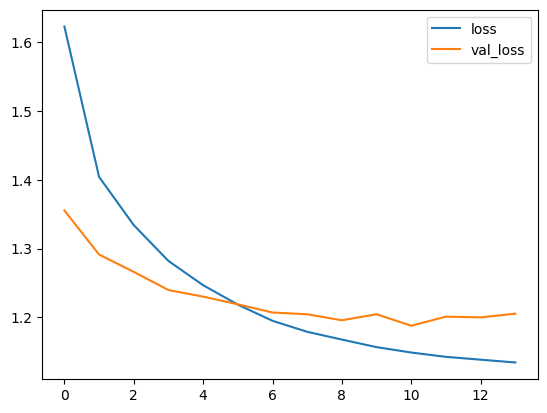

In [110]:
metrics[["loss", "val_loss"]].plot()

<Axes: >

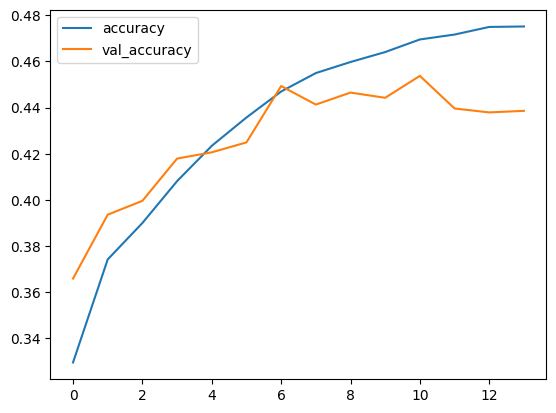

In [111]:
metrics[["accuracy", "val_accuracy"]].plot()

In [112]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

Test loss: 1.2056, Test accuracy: 0.4345


In [113]:
prediction = model.predict(X_test, verbose = 0)
predicted_class = np.argmax(prediction, axis = 1)
true_labels = np.argmax(y_test, axis = 1)

print(classification_report(true_labels, predicted_class, target_names = le.classes_))

              precision    recall  f1-score   support

       adult       0.25      0.23      0.24      1620
 middle-aged       0.23      0.35      0.28       766
       young       0.46      0.44      0.45      2168
 young-adult       0.55      0.52      0.53      4293

    accuracy                           0.43      8847
   macro avg       0.37      0.39      0.38      8847
weighted avg       0.44      0.43      0.44      8847



In [114]:
report = classification_report(true_labels, predicted_class, target_names = le.classes_, output_dict = True)

f1 = report["macro avg"]["f1-score"]
accuracy = report["accuracy"]

scores.append(["Neural Network", accuracy, f1])

# Compare Every Model

In [115]:
scores.sort(key = lambda x: (x[1], x[2]), reverse = True)
scores_df = pd.DataFrame(scores, columns = ["Model", "Accuracy", "Macro F1-Score"])
scores_df

,Model,Accuracy,Macro F1-Score
0,Random Forest: Without Balancing,0.488414,0.335904
1,Decision Tree: Without Balancing,0.464734,0.338215
2,Neural Network,0.434498,0.376296
3,KNN: Without Balancing,0.403357,0.322028
4,Random Forest: With Balancing,0.396236,0.355303
5,KNN: With Balancing,0.388606,0.322707
6,Decision Tree: With Balancing,0.381711,0.345973
7,Dummy Model (Baseline),0.334859,0.249562
